IMPORT MODULES

In [1]:
import torch
from torch import nn
from torchmetrics import Accuracy

from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from helper_functions import plot_decision_boundary

HYPERMARAMETERS

In [2]:
LEARNING_RATE = 0.1
INPUT_SHAPE = 2
HIDDEN_UNITS = 10
OUTPUT_SHAPE = 6
EPOCHS = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CREATE DATASET

In [3]:
X, y = make_gaussian_quantiles(n_samples=2000,
                               n_features=2,
                               n_classes=6,
                               shuffle=True,
                               random_state=402)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
X.shape, y.shape

(torch.Size([2000, 2]), torch.Size([2000]))

VISUALIZE DATA

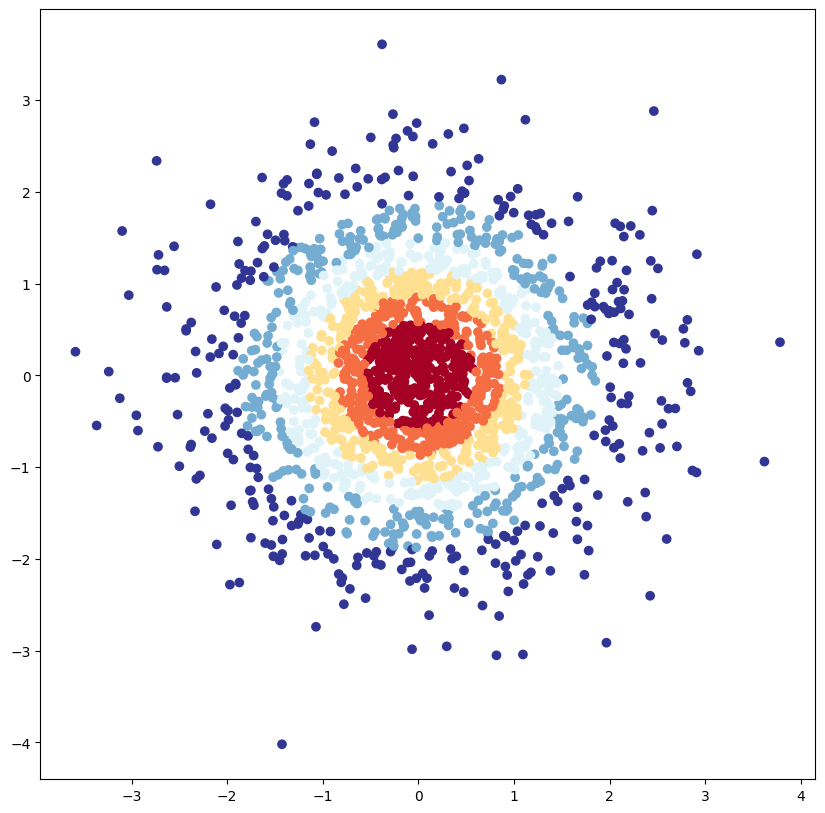

In [4]:
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

CREATE A MODEL

In [5]:
class GaussianClassificationModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layers_stack(x)
    
model = GaussianClassificationModel(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE).to(DEVICE)
model.state_dict()

OrderedDict([('layers_stack.0.weight',
              tensor([[-0.5494, -0.4054],
                      [-0.0466, -0.4771],
                      [ 0.5289,  0.0552],
                      [-0.2613, -0.3959],
                      [-0.4894, -0.0214],
                      [ 0.3091,  0.1913],
                      [ 0.5527, -0.3526],
                      [-0.1051,  0.2956],
                      [ 0.2688, -0.4360],
                      [-0.0508, -0.0909]])),
             ('layers_stack.0.bias',
              tensor([ 0.3819, -0.6119,  0.1718,  0.4907, -0.3251,  0.5297,  0.6657,  0.2023,
                      -0.0842,  0.0680])),
             ('layers_stack.2.weight',
              tensor([[ 0.1086, -0.1447,  0.1372, -0.1915,  0.1189,  0.2035, -0.2747,  0.1588,
                       -0.0928, -0.2692],
                      [-0.0434, -0.0686,  0.0170, -0.2036,  0.1503,  0.2421,  0.0257,  0.1823,
                       -0.3107,  0.1654],
                      [-0.2398, -0.0168, -0.0995, -

TRAINING LOOP

In [6]:
loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=6)
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=LEARNING_RATE)

for epoch in range(1, EPOCHS+1):
    model.train()

    y_train_logits = model(X_train)
    y_train_pred = torch.softmax(y_train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(y_train_logits, y_train)
    train_acc = accuracy(y_train_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy(y_test_pred, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc}")


Epoch: 100 | Train Loss: 1.74 | Train Acc: 0.2862499952316284 | Test Loss: 1.75 | Test Acc: 0.26499998569488525
Epoch: 200 | Train Loss: 1.56 | Train Acc: 0.3868750035762787 | Test Loss: 1.59 | Test Acc: 0.33000001311302185
Epoch: 300 | Train Loss: 1.19 | Train Acc: 0.4818750023841858 | Test Loss: 1.22 | Test Acc: 0.4399999976158142
Epoch: 400 | Train Loss: 0.88 | Train Acc: 0.7862499952316284 | Test Loss: 0.90 | Test Acc: 0.7774999737739563
Epoch: 500 | Train Loss: 0.67 | Train Acc: 0.8737499713897705 | Test Loss: 0.68 | Test Acc: 0.8799999952316284
Epoch: 600 | Train Loss: 0.52 | Train Acc: 0.9024999737739563 | Test Loss: 0.53 | Test Acc: 0.9024999737739563
Epoch: 700 | Train Loss: 0.42 | Train Acc: 0.9281250238418579 | Test Loss: 0.42 | Test Acc: 0.9275000095367432
Epoch: 800 | Train Loss: 0.35 | Train Acc: 0.940625011920929 | Test Loss: 0.35 | Test Acc: 0.9350000023841858
Epoch: 900 | Train Loss: 0.30 | Train Acc: 0.9493749737739563 | Test Loss: 0.30 | Test Acc: 0.9399999976158142


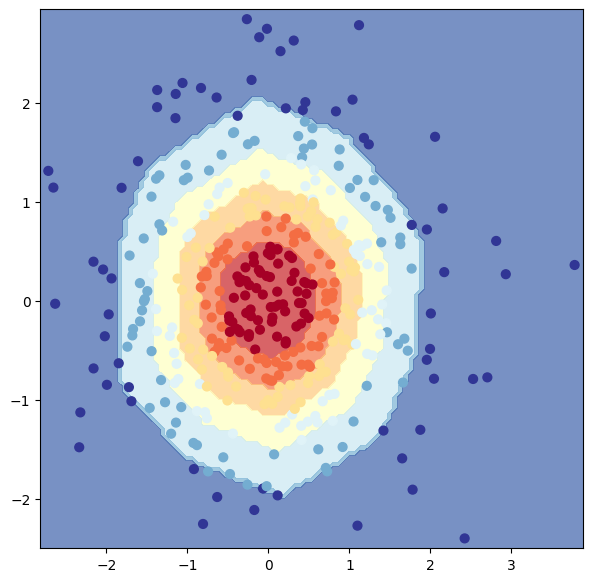

In [7]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model=model, X=X_test, y=y_test)